In [2]:
pip install catboost

     |████████████████████████████████| 12.9 MB 1.1 MB/s eta 0:00:01    |████████████▊                   | 5.1 MB 1.1 MB/s eta 0:00:08
     |████████████████████████████████| 46 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 26.5 MB 9.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install optuna

     |████████████████████████████████| 308 kB 969 kB/s eta 0:00:01
     |████████████████████████████████| 80 kB 9.8 MB/s  eta 0:00:01
     |████████████████████████████████| 209 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 7.2 MB/s  eta 0:00:01
     |████████████████████████████████| 112 kB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 149 kB 5.8 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=0b82a33eaf2d25ba114be742e592051eeed218f08c1e72fdf10db96fa149f594
  Stored in directory: /Users/sam/Library/Caches/pip/wheels/0c/09/9e/49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip
Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [26]:
df = pd.read_csv('student-grades.csv')

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [27]:
df.shape

(395, 33)

In [28]:
df.isnull().values.any()

False

In [29]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [30]:
df.describe(include=[object])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,307,281,354,141,217,145,273,344,242,214,201,314,375,329,263


# Feature Engineering

In [31]:
# create pass and fail column

df['pass'] = np.where(df['G3'] >= 10, 'pass', 'fail')

In [32]:
# create letter grade column

df.loc[df['G3'] < 10, 'Grade'] = 'F'
df.loc[(df['G3'] >= 10) & (df['G3'] <= 11), 'Grade'] = 'D'
df.loc[(df['G3'] >= 12) & (df['G3'] <= 13), 'Grade'] = 'C'
df.loc[(df['G3'] >= 14) & (df['G3'] <= 15), 'Grade'] = 'B'
df.loc[df['G3'] >= 16, 'Grade'] = 'A'

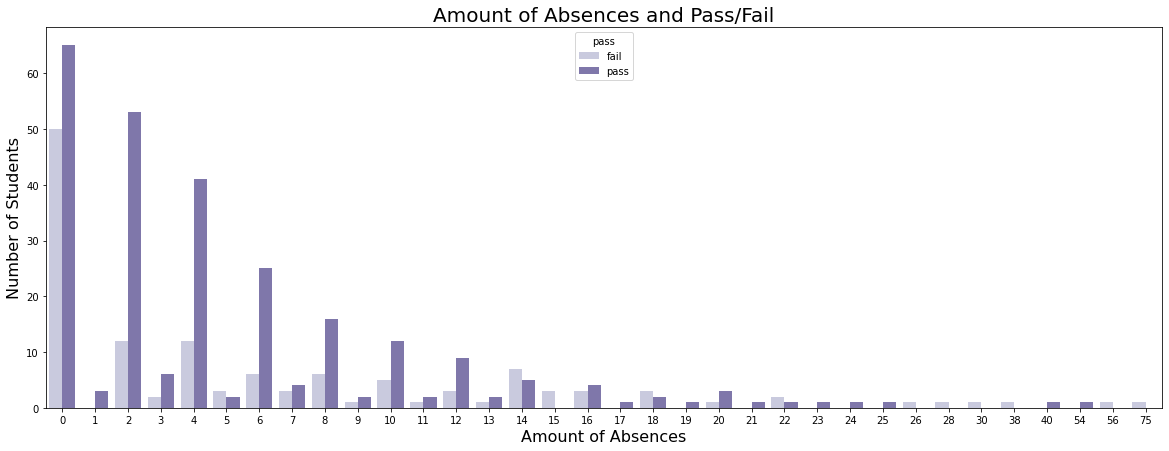

In [33]:
# plot absences vs pass/fail

fig = plt.figure(figsize=(20, 7))

study = sns.countplot(data=df, x="absences", hue="pass", palette='Purples')

plt.title('Amount of Absences and Pass/Fail', fontsize=20)
plt.xlabel('Amount of Absences', fontsize=16)
plt.ylabel('Number of Students', fontsize=16)

plt.show()

In [34]:


df['absences'] = df['absences'].replace([1, 3, 5, 7, 9, 11 ,13, 15, 17, 19, 21, 23, 25],
                       [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])


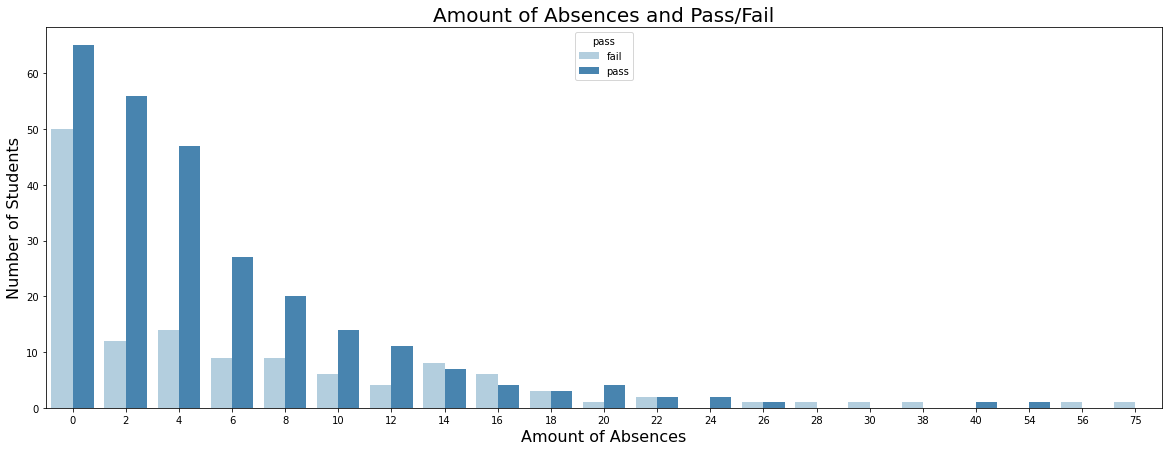

In [35]:
# plot absences vs pass/fail

fig = plt.figure(figsize=(20, 7))

study = sns.countplot(data=df, x="absences", hue="pass", palette='Blues')

plt.title('Amount of Absences and Pass/Fail', fontsize=20)
plt.xlabel('Amount of Absences', fontsize=16)
plt.ylabel('Number of Students', fontsize=16)

plt.show()

In [36]:
# manulally encoding pass column 

fmap = {'pass':1, 'fail':0}

# apply filter to pass column

df['pass'] = df['pass'].map(fmap)

In [37]:
# manually encoding all yes/no varables to ensure yes=1 no=0 

fmap = {'yes':1, 'no':0}

df['schoolsup'] = df['schoolsup'].map(fmap)
df['famsup'] = df['famsup'].map(fmap)
df['paid'] = df['paid'].map(fmap)
df['activities'] = df['activities'].map(fmap)
df['nursery'] = df['nursery'].map(fmap)
df['higher'] = df['higher'].map(fmap)
df['internet'] = df['internet'].map(fmap)
df['romantic'] = df['romantic'].map(fmap)

In [38]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'pass', 'Grade'],
      dtype='object')

# 1) Regression Modeling (Number Grade)

## A) Modeling After the Second Trimester (G1, G2) for Final Grade (G3)

In [39]:
features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
           'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
           'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
           'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
           'Walc', 'health', 'absences', 'G1', 'G2']
target = ['G3']

In [40]:
X = df[features]
y = df[target]

In [41]:
X = np.array(X)
y = np.array(y)

In [43]:

def objective(trial):
    
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    
    pred_labels = np.rint(preds)
    
    accuracy = accuracy_score(valid_y, pred_labels)
    
    return accuracy

In [44]:
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=50, timeout=600)

[I 2021-12-25 15:18:56,523] A new study created in memory with name: no-name-89bcb0bf-b380-4544-bd48-9eb17427299d
[W 2021-12-25 15:18:56,542] Trial 0 failed because of the following error: CatBoostError('Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="MS": Cannot convert \'b\'MS\'\' to float')
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'MS'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_24658/2156690828.py", line 22, in objective
    gbm.fit(train_x, train_y, eval_set=[(valid_x, val

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="MS": Cannot convert 'b'MS'' to float